# Week 3
_LSTMs for Text Generation_

_This journal followed most of [this blog by Megan Risdal](https://www.kaggle.com/mrisdal/intro-to-lstms-w-keras-gpu-for-text-generation)_

This week, we'll apply what we learnt last week with LSTMs to generate text!

For text generation, LSTMs create better sentences than Markov Chains as LSTMs not only account for the last word to create the next word (like Markov Chains), but also account for other recent words before that previous word as well.

As for the data - as I love anything horror - we'll use the [spooky author identification dataset](https://www.kaggle.com/c/spooky-author-identification) on kaggle. We'll take a look at it first.

In [1]:
import numpy as np
import pandas as pd

import string
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

import random

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/spooky-author/train.csv')
dftmp = pd.read_csv('data/spooky-author/test.csv')

orig_df = pd.read_csv('data/spooky-author/train.csv')
orig_df['author'] = orig_df['author'].map(
    {'HPL' : 'HP Lovecraft', 
     'MWS' : 'Mary Shelley', 
     'EAP' : 'Edgar Allan Poe'}
)

df = df.drop('author', axis=1)
df = df.append(dftmp, ignore_index=True)

del dftmp

df.head(2)

id                                               text
0  id26305  This process, however, afforded me no means of...
1  id17569  It never once occurred to me that the fumbling...

## Data Exploration

In [3]:
sum_ = 0
for text in df['text']:    sum_ += len(text.split())
print("Dataset size:\t%d\nAverage Num. Words/Text:\t%f" %(df.shape[0], sum_/df.shape[0]))

Dataset size:	27971
Average Num. Words/Text:	26.655179


That's a terribly small dataset, but it should be ok for our purposes.

Text(0,0.5,'Authors')

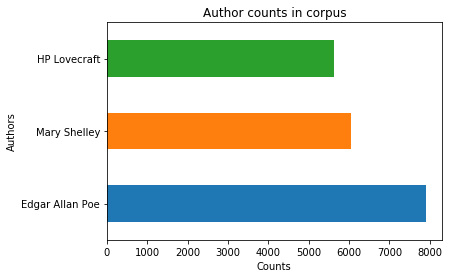

In [4]:
pd.value_counts(orig_df['author'] ).plot.barh()
plt.title('Author counts in corpus')
plt.xlabel('Counts')
plt.ylabel('Authors')

The data is unfortunately skewed towards Poe, but both Lovecraft and Shelley have similar counts of texts. This is assuming that all authors have similar word counts per text, and that the anonymous test data will be similarly distributed.

In [5]:
def get_word_freqs(author):
    cv = CountVectorizer(stop_words='english')
    bag_of_words = cv.fit_transform(orig_df[orig_df['author'] == author]['text'])
    sum_words = bag_of_words.sum(axis=0)
    
    word_freqs = [(word, sum_words[0, index]) for word, index in cv.vocabulary_.items()]
    word_freqs = sorted(word_freqs, key = lambda x: x[1], reverse=True)
    
    return word_freqs

def plot_word_freqs(author, word_freqs, top_n_words=10):
    counts = []
    words = []
    for word, count in word_freqs[author][:top_n_words]:
        words.append(word)
        counts.append(count)
    pd.Series(counts, index=words).plot.barh()
    plt.title(author)
    plt.xlabel('Counts')
    plt.ylabel('Words')

Wall time: 578 ms


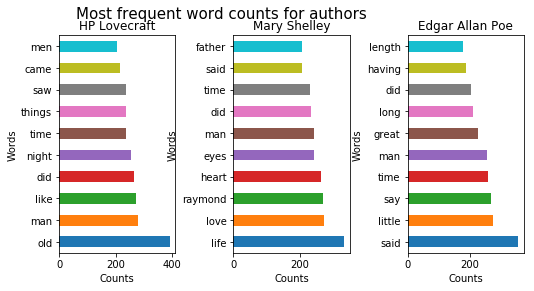

In [6]:
%%time
author_list = list(set(orig_df['author']))
author_word_freqs = {author:get_word_freqs(author) 
                     for author in author_list}

plt.suptitle('Most frequent word counts for authors', fontsize=15)
plt.subplots_adjust(right=1.2, wspace=0.5, hspace=0.5)
for i in range(1,4):
    plt.subplot(1,3,i)
    plot_word_freqs(author_list[i-1], author_word_freqs)

It seems from this dataset, that the authors vocabulary is somewhat varied, the more varied the vocabulary, the more random the text generator will be.

With our small dataset and varied vocabulary, it's quite possible that our machine will make more nonsense sentences.

In [7]:
def get_top_words(author, top_n_words=10):
    words = []
    for word, count in author_word_freqs[author][:top_n_words]:
        words.append(word)
    return words

In [8]:
# Find common words
[word 
 for word in [word 
              for word in get_top_words('Edgar Allan Poe') 
              if word in get_top_words('HP Lovecraft')]
 if word in get_top_words('Mary Shelley')]

['time', 'man', 'did']

Even though these writers are all romantic, that doesn't mean the text generator will be limited to a particular story element or so, as only three specific words are shared by all three authors, and these words in are not especially descriptive.

## Preprocessing

As the LSTM needs a 3D input layer, we need to break it up in a way that our network can read it to learn!

In [3]:
table = str.maketrans({'\n':'.'})
text = orig_df['text'].str.cat()
text = text.translate(table)
text = text.lower()
text[:1000]

'this process, however, afforded me no means of ascertaining the dimensions of my dungeon; as i might make its circuit, and return to the point whence i set out, without being aware of the fact; so perfectly uniform seemed the wall.it never once occurred to me that the fumbling might be a mere mistake.in his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.how lovely is spring as we looked from windsor terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.finding nothing else, not even gold, the superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.a youth passed in solitude, my best years spent under your gentle and feminine fosterage, has so refined the groundwo

As we can see above, our dataset is now just one big whole mass of words.

We want to make it into bite size pieces to make it easier for our model to understand.

First we'll map each unique character to an index. We can't directly use ASCII values because these indexes will themselves be mapped onto the output side of the model.

In [4]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

We'll the dataset/text into tiny pieces, but the catch is that the pieces will have the last character removed as the label/y-value, and it'll look like this:
    > From this sentence: "This sentence is not in English!"
    > With a sequence length of 10 and a step size of 2
    > Piece 1: 'This sente' > y_1: 'n'
    > Piece 2: 's sentence' > y_2: ' ' 
    > Piece 3: 'sentence i' > y_3: 's'
    > etc.

This is so that our model should learn sequences of real words.

In [5]:
seqlen = 30
step = 3
X = []
y = []
for i in range(0, len(text) - seqlen, step):
    seq = text[i: i + seqlen]
    label = text[i + seqlen]
    X.append([char_indices[char] for char in seq])
    y.append(char_indices[label])

Then we must further turn it into a form that's more easily digestible by our model.

In [6]:
enc_X = np.reshape(X, (len(X), seqlen, 1))
enc_X = enc_X / float(len(chars))
enc_y = to_categorical(y)

In [8]:
enc_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Baseline Model

In [8]:
model = Sequential()
model.add(LSTM(128, 
               input_shape=(enc_X.shape[1], enc_X.shape[2]), 
               return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(enc_y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 128)           66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 58)                7482      
Total params: 205,626
Trainable params: 205,626
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(enc_X, enc_y, epochs=1, batch_size=64)

Epoch 1/1
972789/972789 [==============================] - 756s 777us/step - loss: 2.5320


In [10]:
model.save('models/week3baseline')

## Load Baseline Model

In [7]:
# In case you don't want to train everything from scratch
# Preprocessing must be run before you run this from fresh
from keras.models import load_model
model = load_model('models/week3baseline')

## Evaluation

In [12]:
def create_spooky_sent(example):
    tmp = ''
    string_ = example[:seqlen]
    created_sent = [indices_char[value] for value in string_]
    for i in range(seqlen):
        x_i = [word/float(len(chars)) for word in string_]
        x_i = np.reshape(x_i, (1, seqlen, 1))

        pred_index = np.argmax(model.predict(x_i, verbose=0))
        seq = [indices_char[value] for value in string_]
        created_sent.append(indices_char[pred_index])

        string_.append(pred_index)
        string_ = string_[1:len(string_)]


    for char in created_sent:    tmp += char
    tmp = '[' + tmp[:seqlen] + ']' + tmp[seqlen:]
    return tmp

In [9]:
for i in range(0,60,10):
    print(create_spooky_sent(X[i]))

[this process, however, afforde] the serere of the saster of t
[d me no means of ascertaining ]the serere of the saster of th
[the dimensions of my dungeon; ]and the serere of the saster o
[as i might make its circuit, a]nd the serere of the saster of
[nd return to the point whence ]the serere of the saster of th
[i set out, without being aware] the serere of the saster of t


Looks like our model is now prone to repetition, which makes sense as we haven't given it an expansive architecture and enough time to learn, but at least it works.

# Improved

In [7]:
model = Sequential()
model.add(LSTM(450, 
               input_shape=(enc_X.shape[1], enc_X.shape[2]), 
               return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(400))
model.add(Dropout(0.2))
model.add(Dense(enc_y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 450)           813600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 450)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 400)               1361600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 58)                23258     
Total params: 2,198,458
Trainable params: 2,198,458
Non-trainable params: 0
_________________________________________________________________


In [10]:
%%time
checkpoint = ModelCheckpoint(filepath='models/week3better', verbose=1)
model.fit(enc_X, enc_y, epochs=4, batch_size=128, callbacks=[checkpoint])

Epoch 1/4
972789/972789 [==============================] - 5757s 6ms/step - loss: 2.4020

Epoch 00001: saving model to models/week3better
Epoch 2/4
972789/972789 [==============================] - 5733s 6ms/step - loss: 1.9990

Epoch 00002: saving model to models/week3better
Epoch 3/4
972789/972789 [==============================] - 5739s 6ms/step - loss: 1.8484

Epoch 00003: saving model to models/week3better
Epoch 4/4
972789/972789 [==============================] - 5783s 6ms/step - loss: 1.7636

Epoch 00004: saving model to models/week3better
Wall time: 6h 23min 32s


In [ ]:
from keras.models import load_model
model = load_model('models/week3better')

In [13]:
for i in range(0,60,10):
    print(create_spooky_sent(X[i]))

[this process, however, afforde]d the sime of the simgle simen
[d me no means of ascertaining ]and consinued the sime of the 
[the dimensions of my dungeon; ]and the sea of the simgle sea 
[as i might make its circuit, a]nd the surpect of the simgle s
[nd return to the point whence ]the sime of the simgle siment 
[i set out, without being aware] the sime of the simgle siment


Still rather lacking, but hey, we got something that's better than our last model. The generated sentences are more varied than our last model, but they are still concentrated onto jibberish and go to particular phrases, such as `simgle simen`.